In [1]:
import pyfastchem as pyfc
import os
import petitRADTRANS.physical_constants as nc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from tqdm import tqdm

In [2]:
class FastChemistry():

    def __init__(self, pressures):

        self.pressures = pressures

        # pyfc_path = os.path.dirname(pyfc.__file__)
        pyfc_path = os.path.abspath('/net/lem/data1/regt/fastchem/')
        self.element_file   = f'{pyfc_path}/input/element_abundances/asplund_2020_extended.dat'
        self.logK_gas_file  = f'{pyfc_path}/input/logK/logK_extended.dat'
        self.logK_cond_file = f'{pyfc_path}/input/logK/logK_condensates.dat'

        self.fastchem = pyfc.FastChem(
            self.element_file, self.logK_gas_file, self.logK_cond_file, 1
            )

        # Create in/out-put structures for FastChem
        self.input = pyfc.FastChemInput()
        self.input.pressure = self.pressures[::-1] # Flip to decrease

        self.output = pyfc.FastChemOutput()

        # Use equilibrium condensation
        self.input.equilibrium_condensation = True
        # Use rainout condensation approach
        self.input.rainout_condensation     = True
        #self.input.rainout_condensation     = False

        # Configure FastChem's internal parameters
        self.fastchem.setParameter('accuracyChem', 1e-6)
        self.fastchem.setParameter('accuracyElementConservation', 1e-6)
        #self.fastchem.setParameter('accuracyNewton', 1e-5)
        
        self.fastchem.setParameter('nbIterationsChem', 100000)
        #self.fastchem.setParameter('nbIterationsNewton', 10000)
        #self.fastchem.setParameter('nbIterationsNelderMead', 10000)

        # ------------------------------------------------------------------

        # Make a copy of the solar abundances from FastChem
        self.solar_abundances = np.array(self.fastchem.getElementAbundances())

        # Indices of carbon-bearing species
        self.index_C = np.array(self.fastchem.getElementIndex('C'))
        self.index_O = np.array(self.fastchem.getElementIndex('O'))

        # Compute the solar C/O ratio
        self.CO_solar = self.solar_abundances[self.index_C] / \
            self.solar_abundances[self.index_O]

        # Indices of H/He-bearing species
        index_H  = np.array(self.fastchem.getElementIndex('H'))
        index_He = np.array(self.fastchem.getElementIndex('He'))

        self.mask_metal = np.ones_like(self.solar_abundances, dtype=bool)
        self.mask_metal[index_H]  = False
        self.mask_metal[index_He] = False

    def get_VMR(self, species_i):
        index = self.fastchem.getGasSpeciesIndex(species_i)
        return self.VMR[:,index]
    
    def get_condensate_number_density(self, species_i):
        index = self.fastchem.getCondSpeciesIndex(species_i)
        return np.array(self.output.number_densities_cond)[::-1,index]
    
    def get_element_number_density(self, element_i):
        
        gas_indices = [self.fastchem.getGasSpeciesIndex(element_i)]
        cond_indices = []

        with open(self.logK_gas_file, 'r') as fp:
            for line in fp:
                if f' {element_i} ' in line:
                    species_i = line.split(' ')[0]
                    index_i   = self.fastchem.getGasSpeciesIndex(species_i)

                    gas_indices.append(index_i)

        with open(self.logK_cond_file, 'r') as fp:
            for line in fp:
                if f' {element_i} ' in line:
                    species_i = line.split(' ')[0]
                    index_i   = self.fastchem.getCondSpeciesIndex(species_i)

                    cond_indices.append(index_i)
                    
        gas_tot = np.sum(
            np.array(self.output.number_densities)[:,gas_indices], axis=1
        )
        cond_tot = np.sum(
            np.array(self.output.number_densities_cond)[:,cond_indices], axis=1
        )

        return gas_tot + cond_tot

    def __call__(self, T, CO, FeH):

        temperature = T * np.ones_like(self.pressures)
        if (temperature < 150).any():
            print('Replaced T<150 with T=150 K')
            temperature[temperature<150] = 150

        self.input.temperature = temperature[::-1] # Flip for FastChem usage

        # Make a copy to modify the elemental abundances
        element_abundances = self.solar_abundances.copy()
        metallicity_wrt_solar = 10**FeH

        # Apply C/O ratio and Fe/H to elemental abundances
        CO_correction = (1 + element_abundances[self.index_C]/element_abundances[self.index_O]) / (1+CO)

        element_abundances[self.index_C] = element_abundances[self.index_O] * CO
        
        element_abundances[self.index_C] *= CO_correction
        element_abundances[self.index_O] *= CO_correction

        element_abundances[self.mask_metal] *= metallicity_wrt_solar

        # Update the element abundances
        self.fastchem.setElementAbundances(element_abundances)

        # Compute the number densities
        fastchem_flag = self.fastchem.calcDensities(self.input, self.output)

        if fastchem_flag != 0:
            # FastChem failed to converge
            print('Failed to converge')
        if np.amin(self.output.element_conserved) != 1:
            # Failed element conservation
            print('Failed element conservation')

        # Compute the volume-mixing ratio of all species
        self.gas_number_density_tot = np.array(self.input.pressure)*1e6 / \
            (nc.kB * np.array(self.input.temperature))
        gas_number_density     = np.array(self.output.number_densities)

        self.VMR = gas_number_density / self.gas_number_density_tot[:,None]
        self.VMR = self.VMR[::-1] # Flip back

In [3]:
#T_eff = np.arange(700, 2400+1e-6, 100)
T_eff = np.arange(700, 2400+1e-6, 300)
#T_eff = np.array([700,1000])
# T_eff = np.array([700, 1600, 1000, 1900, 1300, 2200])
T_eff = np.array([700, 1000, 1300, 1600, 1900, 2200])

# VMR_tot = {'F': [], 'Fe': []}
# VMR  = {'F1H1': [], 'Fe': [], 'Fe1H1': [], 'Mg': [], 'Al1F1': [], 'Na': [], 'K': []}
VMR_tot = {'F': [], 'C': [], 'O': [], 'S': [], 'N': []}
VMR  = {'F1H1': [], 'C1O1': [], 'C1H4': [], 'H2O1': [], 'C1O2': [], 'H1O1': [], 'H2S1': [], 'H3N1': []}
cond = {'Al2O3(s,l)': [], 'Al2SiO5(s)': [], 'KAlSi3O8(s)': [], 'NaAlSi3O8(s)': [], 'CH4(s,l)': []}
P = []
T = []

for FeH_i in [-0.5,0.0,0.5]:
#for FeH_i in [0.0]:
    for T_eff_i in tqdm(T_eff):

        # Read temperature profile
        #path = '/home/sam/Documents/PhD/fastchem_tests/SONORA_ElfOwl_PT/' + \
        path = '/net/lem/data2/regt/SONORA_Elf_Owl/PT_profiles/' + \
            'spectra_logzz_7.0_teff_{:.1f}_grav_1000.0_mh_{:.1f}_co_1.0.dat'.format(T_eff_i, FeH_i)
            #'spectra_logzz_9.0_teff_{:.1f}_grav_1000.0_mh_0.0_co_1.0.dat'.format(T_eff_i)
        pressure, temperature = np.loadtxt(path).T

        # Compute the chemical equilibrium abundances
        FC = FastChemistry(pressures=pressure)
        #FC(T=temperature, CO=0.59, FeH=0.0)
        FC(T=temperature, CO=0.45, FeH=FeH_i)

        P.append(pressure)
        #T.append(temperature)
        T.append(FC.input.temperature[::-1])

        for hill_i in VMR.keys():
            VMR[hill_i].append(FC.get_VMR(hill_i))
            #VMR[hill_i].append(FC.get_VMR(hill_i)/FC.get_VMR('H2O1'))
        for hill_i in cond.keys():
            cond[hill_i].append(FC.get_condensate_number_density(hill_i))

        for element_i in VMR_tot.keys():
            VMR_tot_i = FC.get_element_number_density(element_i) \
                / FC.gas_number_density_tot
            VMR_tot[element_i].append(VMR_tot_i[::-1])
        

 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 3/6 [00:22<00:21,  7.15s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initiali

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:42<00:00,  7.06s/it]


KeyError: 'Fe'

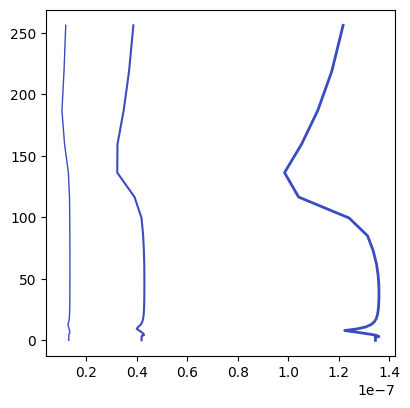

In [4]:
color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1', 'FeH':'#00DBA8', 'Na':'C1'}
cmap = plt.get_cmap('coolwarm')
N = len(T_eff)

fig = plt.figure(figsize=(4.5,4.5))
#fig = plt.figure(figsize=(4,4))
gs = fig.add_gridspec(
    nrows=1, ncols=1, hspace=0.2, wspace=0.08, 
)
ax = np.array([fig.add_subplot(gs[0,0])])

for i, T_eff_i in enumerate(T_eff):
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    ax[0].plot(VMR['F1H1'][i], P[i], c=c, lw=1)
    ax[0].plot(VMR['F1H1'][i+N], P[i+N], c=c, label='{:.0f} K'.format(T_eff_i), lw=1.5)
    ax[0].plot(VMR['F1H1'][i+2*N], P[i+2*N], c=c, lw=2)

    #ax[0].plot(VMR['Fe1H1'][i+N], P[i+N], c=c, lw=1, ls=':')
    ax[0].plot(VMR['Fe'][i+N], P[i+N], c=c, lw=0.7, ls=(0,(4.5,3)))
    
    #ax[0].plot(VMR['Na'][i+N], P[i+N], c=c, lw=0.7, ls=(0,(4.5,3)))
    #ax[0].plot(VMR['K'][i+N], P[i+N], c=c, lw=1, ls='-.')
    #ax[0].plot(VMR['Mg'][i+N], P[i+N], c=c, lw=1, ls=':')
    
    #ax[0].plot(VMR['Al1F1'][i+N], P[i+N], c=c, ls=':')

'''
color_A = '#FF622E'; color_B = '#396ED8'
for VMR_posterior_i, P_i, color_i in zip([VMR_posterior_A, VMR_posterior_B], [1,1.4], [color_A, color_B]):
    x = np.median(VMR_posterior_i['HF'][:,0])
    #xerr = np.quantile(VMR_posterior_i['HF'][:,0], q=q[[2,4]]) - x
    xerr = np.quantile(VMR_posterior_i['HF'][:,0], q=q[[0,-1]]) - x
    xerr = np.abs(xerr)[:,None]
    ax[0].errorbar(x=x, y=P_i, xerr=xerr, fmt='.', c=color_i, markersize=6, lw=1.5, capthick=1.5, capsize=2)
'''

ann_kwargs = dict(
    xycoords=ax[0].get_xaxis_transform(), 
    ha='center', va='bottom', c=color_species['HF'], 
    fontsize=11, fontweight='bold', 
)

xticks = []
for VMR_i, label_i, lw_i in zip(np.array(VMR_tot['F'])[[0,N,2*N],-1], [r'$-0.5$',''r'$0$',r'$+0.5$'], [1,1.5,2]):
    ax[0].axvline(VMR_i, c=color_species['HF'], lw=lw_i, ls=(0,(4,2)), zorder=-1)
    ax[0].axvline(VMR_i, ymin=1, ymax=1.01, clip_on=False, c=color_species['HF'], lw=lw_i, zorder=-1)
    ax[0].annotate(label_i, xy=(VMR_i, 1.01), **ann_kwargs)
ax[0].annotate(r'$\mathrm{[F/H]}$', xy=(VMR_tot['F'][N][-1], 1.07), **ann_kwargs)

#ax[0].axvline(VMR_tot['Fe'][N][-1], c=color_species['FeH'], lw=1, ls=(0,(4,2)), zorder=-1)

ann_kwargs['fontsize'] = 14
ann_kwargs['path_effects'] = [pe.withStroke(linewidth=5, foreground='w', alpha=0.9)]
ax[0].annotate('HF', xy=(VMR['F1H1'][N][0], 0.6), clip_on=True, **ann_kwargs)

ann_kwargs['c'] = color_species['FeH']
ax[0].annotate('Fe', xy=(VMR['Fe'][N][-5], 0.2), clip_on=True, **ann_kwargs)

#ann_kwargs['c'] = color_species['Na']
#ax[0].annotate('Na', xy=(VMR['Na'][N][69], 0.5), clip_on=True, **ann_kwargs)

ax[0].legend(
    loc='upper right', bbox_to_anchor=(1,1), ncols=2, edgecolor='none', 
    columnspacing=1.2, handlelength=0.6, handletextpad=0.4, handleheight=0.3, 
    labelcolor='linecolor', prop={'size':11}, 
    title=r'${\bf T_{eff}}$', title_fontsize=12,
)
ax[0].set(
    xscale='log', yscale='log', ylim=(1e3,1e-5), xlim=(3e-9,8e-5), 
    #xlim=(5e-9,3e-6), 
    xlabel='VMR', ylabel=r'$P\ (\mathrm{bar})$'
)

plt.subplots_adjust(left=0.17, bottom=0.12, top=0.88, right=0.97)
plt.savefig('./plots/HF_VMR.pdf')
plt.show()

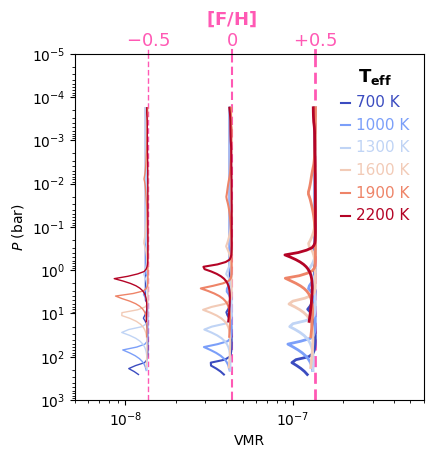

In [ ]:
fig = plt.figure(figsize=(4.5,4.5))
#fig = plt.figure(figsize=(4,4))
gs = fig.add_gridspec(
    nrows=1, ncols=1, hspace=0.2, wspace=0.08, 
)
ax = np.array([fig.add_subplot(gs[0,0])])

for i, T_eff_i in enumerate(T_eff):
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    ax[0].plot(VMR['F1H1'][i], P[i], c=c, lw=1)
    ax[0].plot(VMR['F1H1'][i+N], P[i+N], c=c, label='{:.0f} K'.format(T_eff_i), lw=1.5)
    ax[0].plot(VMR['F1H1'][i+2*N], P[i+2*N], c=c, lw=2)

ann_kwargs = dict(
    xycoords=ax[0].get_xaxis_transform(), ha='center', va='bottom', c=color_species['HF'], fontsize=13, fontweight='bold', 
)
for VMR_i, label_i, lw_i in zip(np.array(VMR_tot['F'])[[0,N,2*N],-1], [r'$-0.5$',''r'$0$',r'$+0.5$'], [1,1.5,2]):
    ax[0].axvline(VMR_i, c=color_species['HF'], lw=lw_i, ls=(0,(4,2)), zorder=-1)
    ax[0].axvline(VMR_i, ymin=1, ymax=1.01, clip_on=False, c=color_species['HF'], lw=lw_i, zorder=-1)
    ax[0].annotate(label_i, xy=(VMR_i, 1.01), **ann_kwargs)
ax[0].annotate(r'$\mathrm{\bf [F/H]}$', xy=(VMR_tot['F'][N][-1], 1.07), **ann_kwargs)


ax[0].legend(
    loc='upper right', bbox_to_anchor=(1,1), ncols=1, edgecolor='none', 
    columnspacing=1.2, handlelength=0.6, handletextpad=0.4, handleheight=0.3, 
    labelcolor='linecolor', prop={'size':11}, 
    title=r'${\bf T_{eff}}$', title_fontsize=13,
)
ax[0].set(
    xscale='log', yscale='log', ylim=(1e3,1e-5), xlim=(5e-9,6e-7), 
    xlabel='VMR', ylabel=r'$P\ (\mathrm{bar})$', 
)
plt.show()

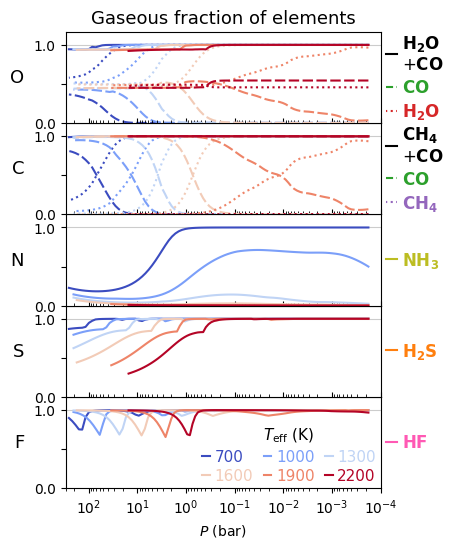

In [ ]:
color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1'}
cmap = plt.get_cmap('coolwarm')
N = len(T_eff)

fig = plt.figure(figsize=(4.5,5.5))
gs = fig.add_gridspec(nrows=5, ncols=1, hspace=0.0)
ax = np.array([
    fig.add_subplot(gs[4,0]), 
    fig.add_subplot(gs[3,0]), 
    fig.add_subplot(gs[2,0]), 
    fig.add_subplot(gs[1,0]), 
    fig.add_subplot(gs[0,0]), 
])
ax = ax[::-1]



for i, T_eff_i in enumerate(T_eff):

    zorder = np.argwhere(np.sort(T_eff)==T_eff_i)[0][0]
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    # for j, lw in zip([i,i+N,i+2*N], [1,1.5,2]):
    for j, lw in zip([i+N], [1.5]):
        # O, C, N, S, F
        ax[0].plot(P[j], (VMR['C1O1'][j]+VMR['H2O1'][j])/VMR_tot['O'][j], c=c, lw=lw, zorder=zorder)
        ax[0].plot(P[j], VMR['C1O1'][j]/VMR_tot['O'][j], c=c, lw=lw, ls=(0,(5,1.65)), zorder=zorder)
        ax[0].plot(P[j], VMR['H2O1'][j]/VMR_tot['O'][j], c=c, lw=lw, ls=(0,(1,1.65)), zorder=zorder)

        ax[1].plot(P[j], (VMR['C1O1'][j]+VMR['C1H4'][j])/VMR_tot['C'][j], c=c, lw=lw, zorder=zorder)
        ax[1].plot(P[j], VMR['C1O1'][j]/VMR_tot['C'][j], c=c, lw=lw, ls=(0,(5,1.65)), zorder=zorder)
        ax[1].plot(P[j], VMR['C1H4'][j]/VMR_tot['C'][j], c=c, lw=lw, ls=(0,(1,1.65)), zorder=zorder)

        ax[2].plot(P[j], VMR['H3N1'][j]/VMR_tot['N'][j], c=c, lw=lw, zorder=zorder)
        ax[3].plot(P[j], VMR['H2S1'][j]/VMR_tot['S'][j], c=c, lw=lw, zorder=zorder)
        ax[4].plot(P[j], VMR['F1H1'][j]/VMR_tot['F'][j], c=c, lw=lw, zorder=zorder, label='{:.0f}'.format(T_eff_i))
    
# ax[0].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf CO}$+'+'\n'+r'$\mathrm{\bf H_2O}$')
ax[0].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf H_2O}$'+'\n+'+r'$\mathrm{\bf CO}$')
ax[0].plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.6,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax[0].plot(np.nan, np.nan, c=color_species['H2O'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf H_2O}$')

ax[1].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf CH_4}$'+'\n+'+r'$\mathrm{\bf CO}$')
ax[1].plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.6,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax[1].plot(np.nan, np.nan, c=color_species['CH4'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf CH_4}$')
ax[2].plot(np.nan, np.nan, c=color_species['NH3'], lw=lw, label=r'$\mathrm{\bf NH_3}$')
ax[3].plot(np.nan, np.nan, c=color_species['H2S'], lw=lw, label=r'$\mathrm{\bf H_2S}$')
ax_4 = ax[4].twinx()
ax_4.axis('off')
ax_4.plot(np.nan, np.nan, c=color_species['HF'], lw=lw, label=r'$\mathrm{\bf HF}$')

legend_kwargs = dict(
    edgecolor='none', facecolor='none', 
    labelcolor='linecolor', prop={'size':12}, handlelength=0.7, handletextpad=0.3, 
    borderpad=0.1, borderaxespad=0.2, labelspacing=0.3, #markerfirst=False,
)
ax[0].legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)
ax[1].legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)
ax[2].legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)
ax[3].legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)
ax_4.legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)

ax[-1].legend(
    loc='lower right', bbox_to_anchor=(1,0), ncols=3, edgecolor='none', facecolor='none', 
    columnspacing=0.7, handlelength=0.5, handletextpad=0.3, labelspacing=0.3, 
    labelcolor='linecolor', prop={'size':11}, borderpad=0.2, borderaxespad=0.1, 
    title=r'$T_\mathrm{eff}\ \mathrm{(K)}$', title_fontsize=11, 
)
ax[0].set_title('Gaseous fraction of elements', fontsize=13)#, fontweight='bold')

for i, ax_i in enumerate(ax):
    ax_i.set(
        xscale='log', #xlim=(1e3,1e-5), 
        xlim=(3e2,1e-4), 
        ylim=(0.,1.17), yticks=[0,0.5,1], yticklabels=['0.0','','1.0'],
        # ylim=(0.85,1.1), 
    )
    ax_i.axhline(1, c='k', lw=0.8, alpha=0.2, zorder=-1)
    if i != len(ax)-1:
        ax_i.set(xticklabels=[])
        ax_i.tick_params('x', which='both', direction='in')
    else:
        ax_i.set(xlabel=r'$P\ (\mathrm{bar})$')
        
    # if i != 0:
    #     ax_i.tick_params('x', which='both', top=True)
    
    ax_i.set_ylabel(['O', 'C', 'N', 'S', 'F'][i], fontsize=13, rotation=0, ha='right', va='center', labelpad=7)

    # t0, *_, t1 = ax_i.yaxis.get_majorticklabels()
    # t0.set_verticalalignment('bottom')
    # t1.set_verticalalignment('top')

plt.subplots_adjust(left=0.14, bottom=0.1, top=0.93, right=0.84)
plt.savefig(f'./plots/gaseous_fraction.pdf')
plt.show()

<>:123: SyntaxWarning: invalid escape sequence '\m'
<>:123: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/regt/ipykernel_129330/3605982601.py:123: SyntaxWarning: invalid escape sequence '\m'
  '''


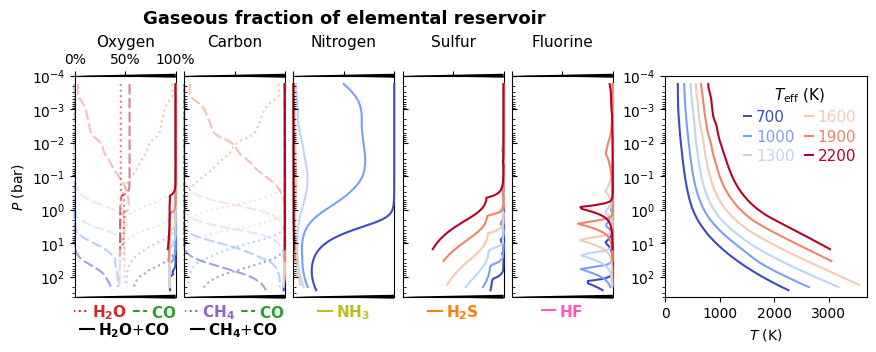

"\nfor i, T_eff_i in enumerate(T_eff):\n\n    zorder = np.argwhere(np.sort(T_eff)==T_eff_i)[0][0]\n    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))\n\n    # for j, lw in zip([i,i+N,i+2*N], [1,1.5,2]):\n    for j, lw in zip([i+N], [1.5]):\n        # O, C, N, S, F\n        ax[0].plot(P[j], (VMR['C1O1'][j]+VMR['H2O1'][j])/VMR_tot['O'][j], c=c, lw=lw, zorder=zorder)\n        ax[0].plot(P[j], VMR['C1O1'][j]/VMR_tot['O'][j], c=c, lw=lw, ls=(0,(5,1.65)), zorder=zorder)\n        ax[0].plot(P[j], VMR['H2O1'][j]/VMR_tot['O'][j], c=c, lw=lw, ls=(0,(1,1.65)), zorder=zorder)\n\n        ax[1].plot(P[j], (VMR['C1O1'][j]+VMR['C1H4'][j])/VMR_tot['C'][j], c=c, lw=lw, zorder=zorder)\n        ax[1].plot(P[j], VMR['C1O1'][j]/VMR_tot['C'][j], c=c, lw=lw, ls=(0,(5,1.65)), zorder=zorder)\n        ax[1].plot(P[j], VMR['C1H4'][j]/VMR_tot['C'][j], c=c, lw=lw, ls=(0,(1,1.65)), zorder=zorder)\n\n        ax[2].plot(P[j], VMR['H3N1'][j]/VMR_tot['N'][j], c=c, lw=lw, zorder=zorder)\n        ax[3].plot(P[j

In [155]:
color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1'}
cmap = plt.get_cmap('coolwarm')
N = len(T_eff)

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=7, wspace=0.08, width_ratios=[0.2,0.2,0.2,0.2,0.2,0.07,0.4])
ax = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[0,1]), 
    fig.add_subplot(gs[0,2]), 
    fig.add_subplot(gs[0,3]), 
    fig.add_subplot(gs[0,4]), 
    fig.add_subplot(gs[0,-1]), 
])

for i, T_eff_i in enumerate(T_eff):

    zorder = np.argwhere(np.sort(T_eff)==T_eff_i)[0][0]-10
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    kwargs = dict(
        c=c, lw=1.5, zorder=zorder, clip_on=False,
    )

    ax[-1].plot(T[i], P[i], c=c, lw=1.5, label='{:.0f}'.format(T_eff_i))

    # for j, lw in zip([i,i+N,i+2*N], [1,1.5,2]):
    for j, lw in zip([i+N], [1.5]):
        # O, C, N, S, F
        ax[0].plot((VMR['C1O1'][j]+VMR['H2O1'][j])/VMR_tot['O'][j], P[j], **kwargs)
        ax[0].plot(VMR['C1O1'][j]/VMR_tot['O'][j], P[j], ls=(0,(5,1.65)), alpha=0.5, **kwargs)
        ax[0].plot(VMR['H2O1'][j]/VMR_tot['O'][j], P[j], ls=(0,(1,1.65)), alpha=0.5, **kwargs)

        ax[1].plot((VMR['C1O1'][j]+VMR['C1H4'][j])/VMR_tot['C'][j], P[j], **kwargs)
        ax[1].plot(VMR['C1O1'][j]/VMR_tot['C'][j], P[j], ls=(0,(5,1.65)), alpha=0.5, **kwargs)
        ax[1].plot(VMR['C1H4'][j]/VMR_tot['C'][j], P[j], ls=(0,(1,1.65)), alpha=0.5, **kwargs)

        ax[2].plot(VMR['H3N1'][j]/VMR_tot['N'][j], P[j], **kwargs)
        ax[3].plot(VMR['H2S1'][j]/VMR_tot['S'][j], P[j], **kwargs)
        ax[4].plot(VMR['F1H1'][j]/VMR_tot['F'][j], P[j], **kwargs)

from matplotlib.patches import Polygon

ax[-1].legend(
    loc='upper right', bbox_to_anchor=(1,1), ncols=2, edgecolor='none', facecolor='none', 
    columnspacing=0.7, handlelength=0.5, handletextpad=0.3, labelspacing=0.3, 
    labelcolor='linecolor', prop={'size':11}, borderpad=0.2, #borderaxespad=0.1, 
    title=r'$T_\mathrm{eff}\ \mathrm{(K)}$', title_fontsize=11, 
)
ax[2].set_title('Gaseous fraction of elemental reservoir', fontsize=13, fontweight='bold', pad=8)
ax[0].set(ylabel=r'$P\ (\mathrm{bar})$')
ax[-1].set(xlabel=r'$T\ (\mathrm{K})$', yscale='log', ylim=(4e2,1e-4), xlim=(0,3700))#, yticklabels=[])
for i, ax_i in enumerate(ax[:-1]):

    xticks = [0,0.5,1]; xticklabels = ['',' ','']
    if i == 0:
        xticks = [0,0.5,1]
        xticklabels = ['0%','50%','100%']

    ax_i.set(yscale='log', ylim=(4e2,1e-4), xlim=(0.,1.), xticks=xticks, xticklabels=xticklabels)
    # ax_i.axvline(1, c='k', lw=0.8, alpha=0.2, zorder=-1)

    if i != 0:
        ax_i.set(yticklabels=[])
        ax_i.tick_params('y', which='both', direction='in')

    ax_i.spines['right'].set_zorder(-100)

    # ax_i.set(xscale='log', xlim=(0.05,3))
    # w = 0.039
    # w = 0.022
    w = 0.018
    p = Polygon([[0,0],[1,w/2],[1,-w/2]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    ax_i.add_patch(p)
    p = Polygon([[0,1],[1,1+w/2],[1,1-w/2]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    ax_i.add_patch(p)

    ax_i.xaxis.set_label_position('top')
    ax_i.xaxis.tick_top()

kwargs = dict(fontsize=11, labelpad=4)
ax[0].set_xlabel('Oxygen', **kwargs)
ax[1].set_xlabel('Carbon', **kwargs)
ax[2].set_xlabel('Nitrogen', **kwargs)
ax[3].set_xlabel('Sulfur', **kwargs)
ax[4].set_xlabel('Fluorine', **kwargs)

# Add legends to each axis
legend_kwargs = dict(
    loc='upper center', edgecolor='none', facecolor='none', 
    labelcolor='linecolor', prop={'size':11}, handlelength=0.9, handletextpad=0.25, 
    borderpad=0.1, borderaxespad=0.3, labelspacing=0.3, #markerfirst=False,
    columnspacing=0.4
)
ax[0].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf H_2O}$+$\mathrm{\bf CO}$')
ax[0].legend(bbox_to_anchor=(0.5,-0.08), **legend_kwargs)

ax_0 = ax[0].twinx(); ax_0.axis('off')
ax_0.plot(np.nan, np.nan, c=color_species['H2O'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf H_2O}$')
ax_0.plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.8,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax_0.legend(bbox_to_anchor=(0.5,0), ncols=2, **legend_kwargs)

ax[1].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf CH_4}$+$\mathrm{\bf CO}$')
ax[1].legend(bbox_to_anchor=(0.5,-0.08), **legend_kwargs)

ax_1 = ax[1].twinx(); ax_1.axis('off')
ax_1.plot(np.nan, np.nan, c=color_species['CH4'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf CH_4}$')
ax_1.plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.8,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax_1.legend(bbox_to_anchor=(0.5,0), ncols=2, **legend_kwargs)

ax[2].plot(np.nan, np.nan, c=color_species['NH3'], lw=lw, label=r'$\mathrm{\bf NH_3}$')
ax[3].plot(np.nan, np.nan, c=color_species['H2S'], lw=lw, label=r'$\mathrm{\bf H_2S}$')
ax[4].plot(np.nan, np.nan, c=color_species['HF'], lw=lw, label=r'$\mathrm{\bf HF}$')

ax[2].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)
ax[3].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)
ax[4].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)

plt.subplots_adjust(left=0.09, bottom=0.14, top=0.79, right=0.97)
plt.savefig(f'./plots/gaseous_fraction.pdf')
plt.show()

'''
for i, T_eff_i in enumerate(T_eff):

    zorder = np.argwhere(np.sort(T_eff)==T_eff_i)[0][0]
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    # for j, lw in zip([i,i+N,i+2*N], [1,1.5,2]):
    for j, lw in zip([i+N], [1.5]):
        # O, C, N, S, F
        ax[0].plot(P[j], (VMR['C1O1'][j]+VMR['H2O1'][j])/VMR_tot['O'][j], c=c, lw=lw, zorder=zorder)
        ax[0].plot(P[j], VMR['C1O1'][j]/VMR_tot['O'][j], c=c, lw=lw, ls=(0,(5,1.65)), zorder=zorder)
        ax[0].plot(P[j], VMR['H2O1'][j]/VMR_tot['O'][j], c=c, lw=lw, ls=(0,(1,1.65)), zorder=zorder)

        ax[1].plot(P[j], (VMR['C1O1'][j]+VMR['C1H4'][j])/VMR_tot['C'][j], c=c, lw=lw, zorder=zorder)
        ax[1].plot(P[j], VMR['C1O1'][j]/VMR_tot['C'][j], c=c, lw=lw, ls=(0,(5,1.65)), zorder=zorder)
        ax[1].plot(P[j], VMR['C1H4'][j]/VMR_tot['C'][j], c=c, lw=lw, ls=(0,(1,1.65)), zorder=zorder)

        ax[2].plot(P[j], VMR['H3N1'][j]/VMR_tot['N'][j], c=c, lw=lw, zorder=zorder)
        ax[3].plot(P[j], VMR['H2S1'][j]/VMR_tot['S'][j], c=c, lw=lw, zorder=zorder)
        ax[4].plot(P[j], VMR['F1H1'][j]/VMR_tot['F'][j], c=c, lw=lw, zorder=zorder, label='{:.0f}'.format(T_eff_i))
    
# ax[0].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf CO}$+'+'\n'+r'$\mathrm{\bf H_2O}$')
ax[0].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf H_2O}$'+'\n+'+r'$\mathrm{\bf CO}$')
ax[0].plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.6,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax[0].plot(np.nan, np.nan, c=color_species['H2O'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf H_2O}$')

ax[1].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf CH_4}$'+'\n+'+r'$\mathrm{\bf CO}$')
ax[1].plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.6,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax[1].plot(np.nan, np.nan, c=color_species['CH4'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf CH_4}$')
ax[2].plot(np.nan, np.nan, c=color_species['NH3'], lw=lw, label=r'$\mathrm{\bf NH_3}$')
ax[3].plot(np.nan, np.nan, c=color_species['H2S'], lw=lw, label=r'$\mathrm{\bf H_2S}$')
ax_4 = ax[4].twinx()
ax_4.axis('off')
ax_4.plot(np.nan, np.nan, c=color_species['HF'], lw=lw, label=r'$\mathrm{\bf HF}$')

legend_kwargs = dict(
    edgecolor='none', facecolor='none', 
    labelcolor='linecolor', prop={'size':12}, handlelength=0.7, handletextpad=0.3, 
    borderpad=0.1, borderaxespad=0.2, labelspacing=0.3, #markerfirst=False,
)
ax[0].legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)
ax[1].legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)
ax[2].legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)
ax[3].legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)
ax_4.legend(loc='center left', bbox_to_anchor=(1,0.5), **legend_kwargs)

ax[-1].legend(
    loc='lower right', bbox_to_anchor=(1,0), ncols=3, edgecolor='none', facecolor='none', 
    columnspacing=0.7, handlelength=0.5, handletextpad=0.3, labelspacing=0.3, 
    labelcolor='linecolor', prop={'size':11}, borderpad=0.2, borderaxespad=0.1, 
    title=r'$T_\mathrm{eff}\ \mathrm{(K)}$', title_fontsize=11, 
)
ax[0].set_title('Gaseous fraction of elements', fontsize=13)#, fontweight='bold')

for i, ax_i in enumerate(ax):
    ax_i.set(
        xscale='log', #xlim=(1e3,1e-5), 
        xlim=(3e2,1e-4), 
        ylim=(0.,1.17), yticks=[0,0.5,1], yticklabels=['0.0','','1.0'],
        # ylim=(0.85,1.1), 
    )
    ax_i.axhline(1, c='k', lw=0.8, alpha=0.2, zorder=-1)
    if i != len(ax)-1:
        ax_i.set(xticklabels=[])
        ax_i.tick_params('x', which='both', direction='in')
    else:
        ax_i.set(xlabel=r'$P\ (\mathrm{bar})$')
        
    # if i != 0:
    #     ax_i.tick_params('x', which='both', top=True)
    
    ax_i.set_ylabel(['O', 'C', 'N', 'S', 'F'][i], fontsize=13, rotation=0, ha='right', va='center', labelpad=7)

    # t0, *_, t1 = ax_i.yaxis.get_majorticklabels()
    # t0.set_verticalalignment('bottom')
    # t1.set_verticalalignment('top')

plt.subplots_adjust(left=0.14, bottom=0.1, top=0.93, right=0.84)
plt.savefig(f'./plots/gaseous_fraction.pdf')
plt.show()
'''